# Ring network with MPI using Arbor's python interface

This example shows the usage of mpi in arbor's python backend by using helpers provided by our Python wrapper in a ring network. 
    
To do so, we first have to load our arbor python module 'pyarb' and submodules thereof:

In [1]:
%matplotlib notebook
import sys
import numpy as np
import math
import matplotlib.pyplot as plot

import pyarb as arb
from pyarb import connection
from pyarb import cell_member as cmem

## Create a recipe for ring network

Now, a recipe, that describes the cells and network of a model, can be defined in python by implementing the recipe interface: 

    1) constructor setting the number of cells
    2) function returning the total number of cells in the model
    3) function returning a cell description (mechanism) of soma as well as segment, synapse and stimulus locations 
    4) function returning the number of targets (here: 1 connection to next cell) 
    5) function returning the number of sources (here: 1 connenction from previous cell)
    6) function returning the type of cell with global id gid 
    7) function creating the ring network (incoming connections to each cell)

In [2]:
class ring_recipe(arb.recipe):

    def __init__(self, n=4):
        # The base C++ class constructor must be called first, to ensure that
        # all memory in the C++ class is initialized correctly.
        arb.recipe.__init__(self)
        self.ncells = n

    # The num_cells method that returns the total number of cells in the model
    # must be implemented.
    def num_cells(self):
        return self.ncells

    # The cell_description method returns a cell
    def cell_description(self, gid):
# ================================ SOLUTION 1 ================================ #
        # 1a) Make a soma cell
        cell = arb.make_soma_cell()
        
        # 1b) Add synapse at segment 0 at location 0.5
        loc = arb.segment_location(0, 0.5)
        cell.add_synapse(loc)
        
        # 1c) Add detector with threshold 20 mV
        cell.add_detector(loc, 20)
        
        # 1d) Add stimulus to first cell with gid 0 at t0 = 0 ms for duration of 20 ms with weight 0.01 nA
        if gid==0:
            cell.add_stimulus(loc, 0, 20, 0.01)
        return cell

    def num_targets(self, gid):
        return 1

    def num_sources(self, gid):
        return 1

    # The kind method returns the type of cell with gid.
    # Note: this must agree with the type returned by cell_description.
    def kind(self, gid):
        return arb.cell_kind.cable1d

    # Make a ring network
    def connections_on(self, gid):
# ================================ SOLUTION 1 ================================ #
        # 1e) Define the source of cell with gid as the previous cell with gid-1
        #    caution: close the ring at gid 0
        src = self.num_cells()-1 if gid==0 else gid-1
        return [connection(cmem(src,0), cmem(gid,0), 0.1, 10)]

## Create parallel execution context

First, initialize MPI with Arbor's mpi helpers:

In [3]:
arb.mpi_init();

Then, get MPI communicator:

In [4]:
comm = arb.mpi_comm()

print(comm)

<mpi_comm: MPI_COMM_WORLD>


Then, get the resources and create the parallel execution context

In [5]:
# ================================ SOLUTION 2 ================================ #
# 2a) Get hardware resources
resources = arb.proc_allocation()

# 2b) Create a context which takes the resources and an MPI communicator as input
context = arb.context(resources, comm)

print(context, '\n')

<context: threads 24, gpu yes, distributed MPI ranks 1> 



Here, we have 24 threads, a P100 GPU and one local rank.

### Set up measurements for runtime and consumption
In order to measure the runtime, the memory consumption on CPU and GPU, as well as the energy consumption, we can utilize arbor's meter manager and start the measurement: 

In [6]:
# OPTIONAL            # ================================ SOLUTION 4 ================================ #
# OPTIONAL            # 4a) Initiate meter manager and start the measurement
meters = arb.meter_manager()
meters.start(context)

### Initiate ring network

Next, we create the example ring network with 100 cells and set a checkpoint to measure its creation:

In [7]:
# 2c) Initiate the recipe with 100 cells
n_cells = 100
recipe = ring_recipe(n_cells)

# OPTIONAL            # 4b) i) Set checkpoint 'recipe create'
meters.checkpoint('recipe create', context)

### Partition the simulation over the distributed system

To part the work into segments, we decompose the recipe (and measure again):

In [8]:
# 2d) Partition the simulation over the distributed system which takes the recipe and the context as input
decomp = arb.partition_load_balance(recipe, context)

# OPTIONAL            # 4b) ii) Set checkpoint 'load balance'
meters.checkpoint('load balance', context)

## Build and run the simulation 

Next, we build the simulation, initialize a spike recorder (and measure the simulation initialization):

In [9]:
# ================================ SOLUTION 3 ================================ #
# 3a) Initiate simulation with the recipe, the domain decomposition and the context
sim = arb.simulation(recipe, decomp, context)

# OPTIONAL            # 4b) iii) Set checkpoint 'simulation init'
meters.checkpoint('simulation init', context)

# OPTIONAL            # 4c) Build the spike recorder
recorder = arb.make_spike_recorder(sim)

### Run simulation 

Finally, we can run the simulation for 2000 ms and with time step size 0.025 ms (and measure the simulation run):

In [10]:
# 3b) Run the simulation for 2000 ms with time stepping of 0.025 ms
tSim = 2000
dt = 0.025
sim.run(tSim, dt)

# OPTIONAL            # 4b) iv) Set checkpoint 'simulation run'
meters.checkpoint('simulation run', context)

## Analyze results of meter measurement and spike recordings

After the simulation run is completed, we print the information collected with arbor's meter manager.

In [11]:
# OPTIONAL            # 4d) Make and print meter report
print(arb.make_meter_report(meters, context))


---- meters -------------------------------------------------------------------------------
meter                         time(s)      memory(MB)  memory-gpu(MB)      energy(kJ)
-------------------------------------------------------------------------------------------
recipe create                   2.739           0.001           0.000           0.224
load balance                    1.398           0.001           0.000           0.112
simulation init                 2.237           0.227           8.389           0.186
simulation run                  9.594           0.081           4.194           1.106



With the spike recorder we can now print the occuring spike times at correcponding cells:

In [12]:
print('SPIKES:')

# OPTIONAL            # 4e) Get the recorder`s spikes
spikes = recorder.spikes

# print at most 10 spikes
n_spikes_out = min(len(spikes), 10)
for i in range(n_spikes_out):
    spike = spikes[i]
    print('  cell %2d at %8.3f ms'%(spike.source.gid, spike.time))



if n_spikes_out<len(spikes):
    print('  ...')
    spike = spikes[-1]
    print('  cell %2d at %8.3f ms'%(spike.source.gid, spike.time))

SPIKES:
  cell  0 at    5.375 ms
  cell  1 at   15.700 ms
  cell  2 at   26.025 ms
  cell  3 at   36.350 ms
  cell  4 at   46.675 ms
  cell  5 at   57.000 ms
  cell  6 at   67.325 ms
  cell  7 at   77.650 ms
  cell  8 at   87.975 ms
  cell  9 at   98.300 ms
  ...
  cell 93 at 1998.100 ms


# Visualization of spiking activity

Use a raster plot to visualize spiking activity.

<IPython.core.display.Javascript object>


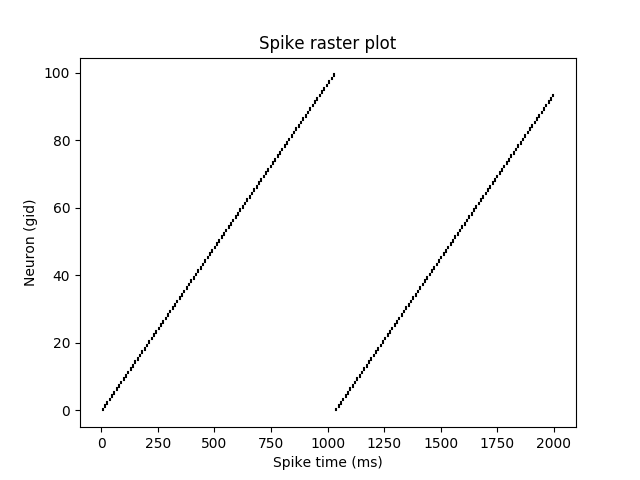

In [17]:
n_spikes = len(spikes)
tVec = np.arange(0,tSim,dt)
SpikeMat_rows = n_cells # number of cells
SpikeMat_cols = math.floor(tSim/dt)
SpikeMat = np.zeros((SpikeMat_rows, SpikeMat_cols))

# save spike trains in matrix: 
# (if spike in cell n at time step k, then SpikeMat[n,k]=1, else 0)
for i in range(n_spikes):
    spike = spikes[i]
    tCur = math.floor(spike.time/dt)
    SpikeMat[spike.source.gid][tCur] = 1

for i in range(SpikeMat_rows):
    for j in range(SpikeMat_cols):
        if(SpikeMat[i,j] == 1):
            x1 = [i,i+0.5]
            x2 = [j,j]
            plot.plot(x2,x1,color = 'black')

plot.title('Spike raster plot')
plot.xlabel('Spike time (ms)')
tick = range(0,SpikeMat_cols+10000,10000)
label = range(0,tSim+250,250)
plot.xticks(tick, label)
plot.ylabel('Neuron (gid)')
plot.show()

## Finalize MPI with Arbor's mpi helper

In [ ]:
arb.mpi_finalize();